# Embedded Method for Feature Selection


Embedded methods integrate the feature selection process directly into the model training process, using techniques such as regularization (e.g., Lasso, Ridge) to penalize irrelevant features. These methods simultaneously train the model and select the most important features, making them efficient and optimized for the given algorithm.


## <span style="color: yellowgreen;">1. </span> Import Libraries


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Normalization, Input, BatchNormalization, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.linear_model import LassoCV

from keras.backend import epsilon
from tensorflow import cast, round, float32, reduce_sum

## <span style="color: yellowgreen;">2. </span> Load the Data


In [7]:
# Load data
data = np.genfromtxt("../../data/labels_features.csv", delimiter=",")
data = data[1:, :]  # Assuming the first row is the header

# Separate features and labels
LABELS = data[:, 1].astype(int)  # Assuming class labels are in the second column
FEATURES = data[:, 2:]  # Assuming features start from the third column

# Define target names
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

## <span style="color: yellowgreen;">3. </span> Split the Data into Training and Test Sets


In [8]:
# Split the data into training and test sets
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(
    FEATURES, LABELS, test_size=test_size, random_state=42, stratify=LABELS
)

## <span style="color: yellowgreen;">4. </span> Feature Selection using Lasso on the Training Set


In [9]:
# Use Lasso for feature selection on the training set
lasso = LassoCV(cv=2)
lasso.fit(x_train, y_train)

# Select features whose coefficients are not zero
selected_features = np.where(lasso.coef_ != 0)[0]

# Apply the selected features to both the training and test sets
x_train = x_train[:, selected_features]
x_test = x_test[:, selected_features]

## <span style="color: yellowgreen;">5. </span> Preprocess the Data


In [10]:
# Convert labels to categorical format
num_labels = len(np.unique(LABELS))
y_cat_train = to_categorical(y_train, num_labels)
y_cat_test = to_categorical(y_test, num_labels)

In [11]:
# Scale features
scaler_object = MinMaxScaler()
scaler_object.fit(x_train)
x_train = scaler_object.transform(x_train)
x_test = scaler_object.transform(x_test)

In [12]:
# Reshape features for the model
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

x_train_shape = x_train[0].shape
x_test_shape = x_test[0].shape

## <span style="color: yellowgreen;">6. </span> Define Custom F1 Score Metric


In [13]:
def f1_score(y_true, y_pred):
    y_true = cast(y_true, float32)
    y_pred = cast(
        round(y_pred), float32
    )  # Assuming y_pred is continuous values, not binary

    TP = reduce_sum(y_true * y_pred)
    FP = reduce_sum(y_pred) - TP
    FN = reduce_sum(y_true) - TP

    precision = TP / (TP + FP + epsilon())
    recall = TP / (TP + FN + epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + epsilon())

    return f1

## <span style="color: yellowgreen;">7. </span> Build the Convolutional Neural Network Model


In [14]:
normalizer = Normalization()
normalizer.adapt(x_train)

model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Reshape((x_train.shape[1], 1)))

model.add(Conv1D(216, 1, activation="relu"))
model.add(Conv1D(80, 1, activation="relu"))
model.add(Conv1D(421, 1, activation="relu"))
model.add(Conv1D(137, 1, activation="relu"))
model.add(Flatten())
model.add(Dropout(0.15650063875581377))
model.add(Dense(199, activation="relu"))
model.add(Dropout(0.15650063875581377))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[f1_score])

## <span style="color: yellowgreen;">8. </span> Train the Model


In [15]:
epochs = 300
withVal = True

# Callbacks
monitor = "loss"
checkpoint = ModelCheckpoint(
    "../../models/xtrain_feature_selection/embedded_method_best_model.h5",
    monitor=monitor,
    save_best_only=True,
    mode="auto",
)
early_stopping = EarlyStopping(monitor=monitor, patience=3, restore_best_weights=True)

trainData = x_train
testData = x_test

if withVal:
    results = model.fit(
        trainData,
        y_train,
        epochs=epochs,
        verbose=3,
        validation_data=(testData, y_test),
        callbacks=[checkpoint, early_stopping],
        batch_size=4,
    )
else:
    results = model.fit(x_train, y_train, epochs=epochs, verbose=3)

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300


## <span style="color: yellowgreen;">9. </span> Evaluate the Model


In [16]:
metric_names = model.metrics_names
scores = model.evaluate(testData, y_test, verbose=0)

print("Metrics:")
for i, name in enumerate(metric_names):
    print("\t%s:   \t%.2f" % (name, scores[i]))

Metrics:
	loss:   	0.65
	f1_score:   	0.83


## <span style="color: yellowgreen;">10. </span> Plot Training Metrics


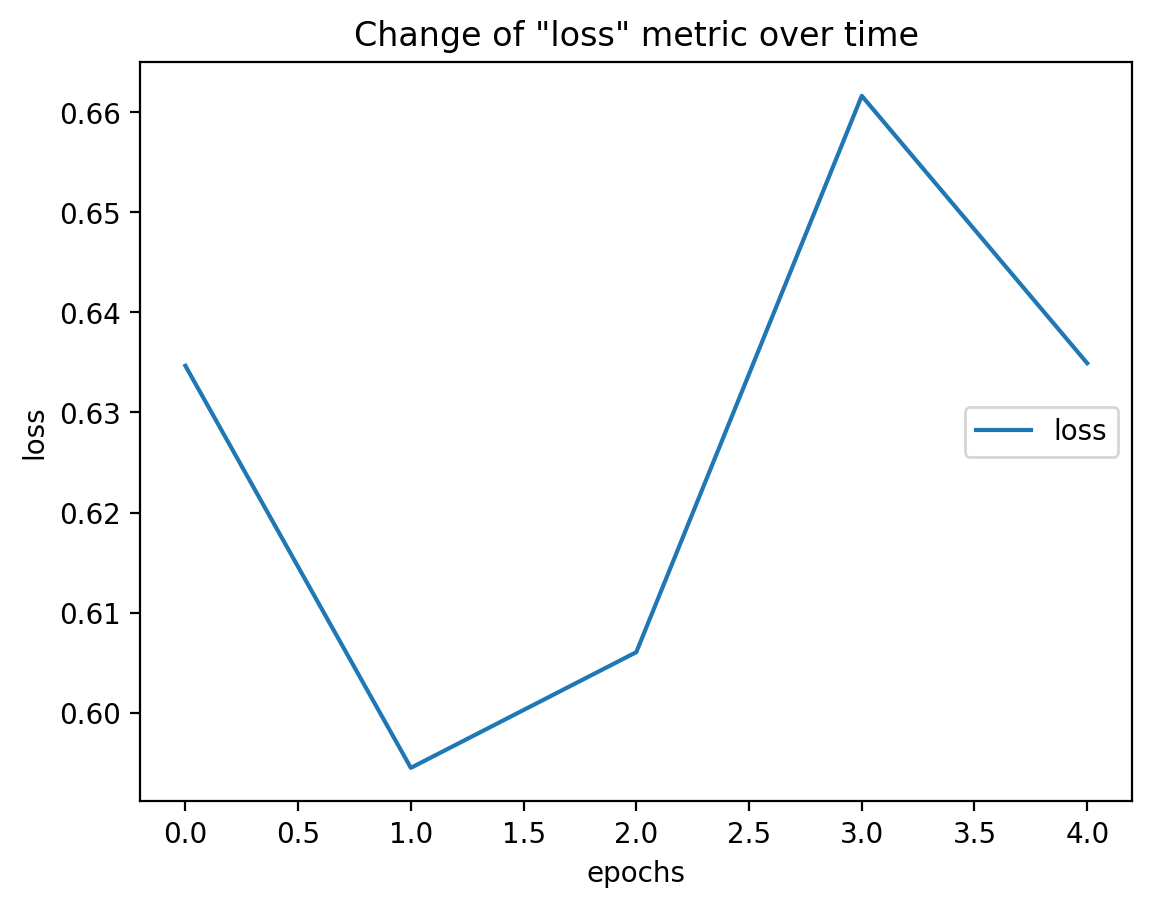

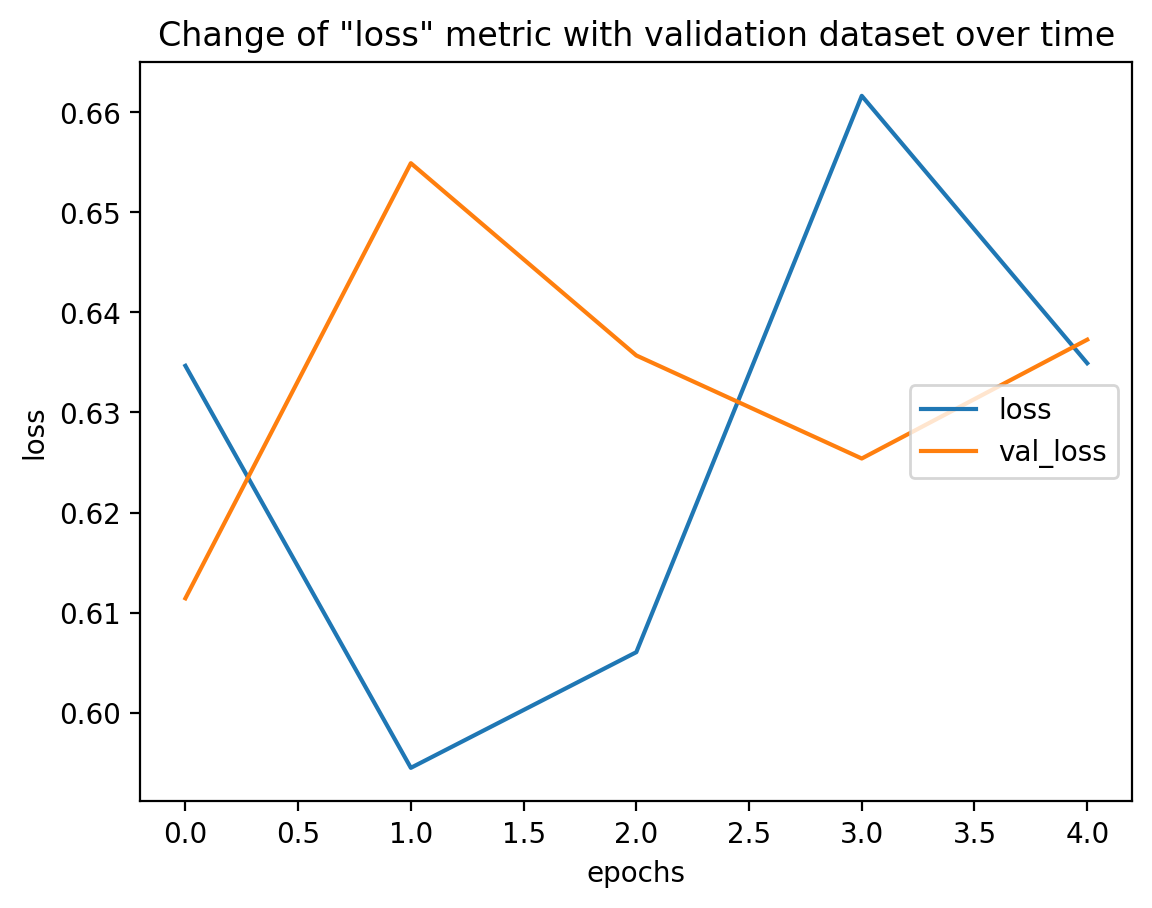

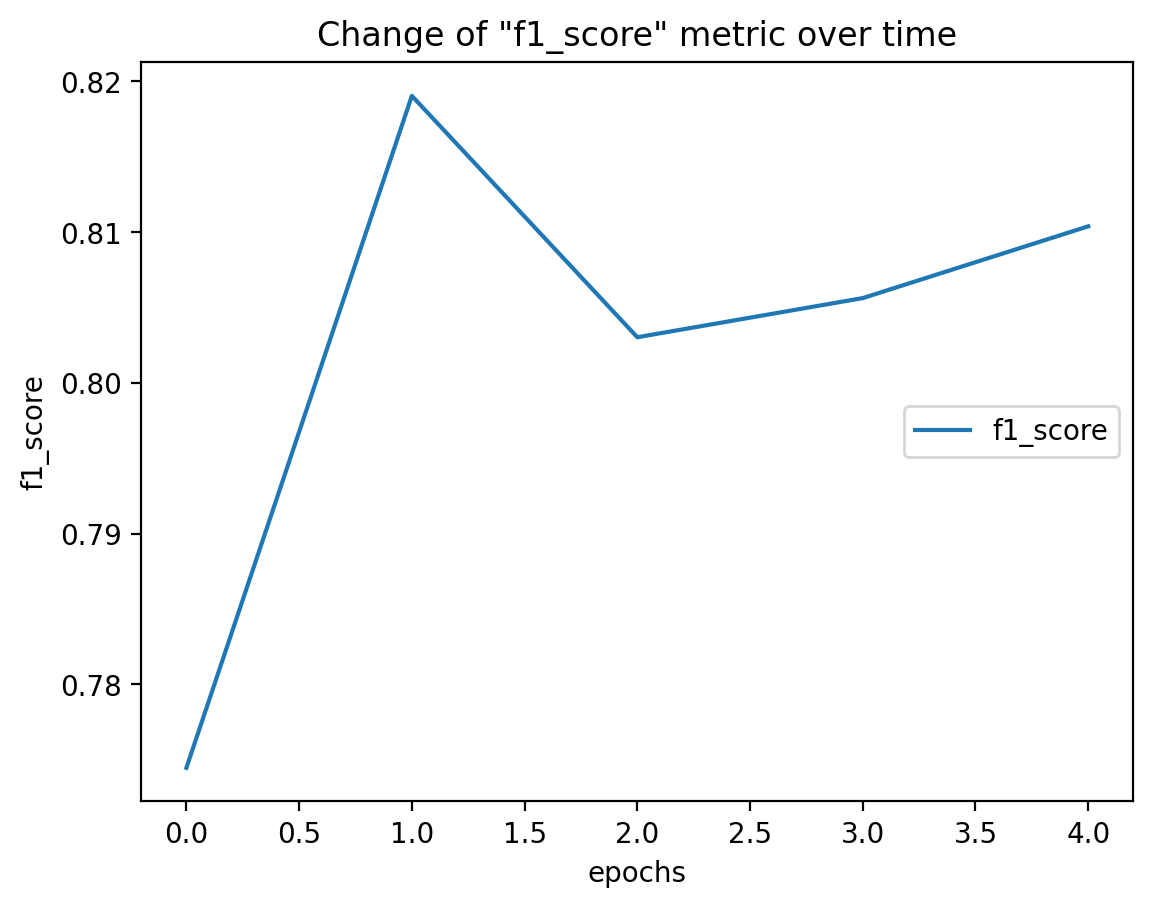

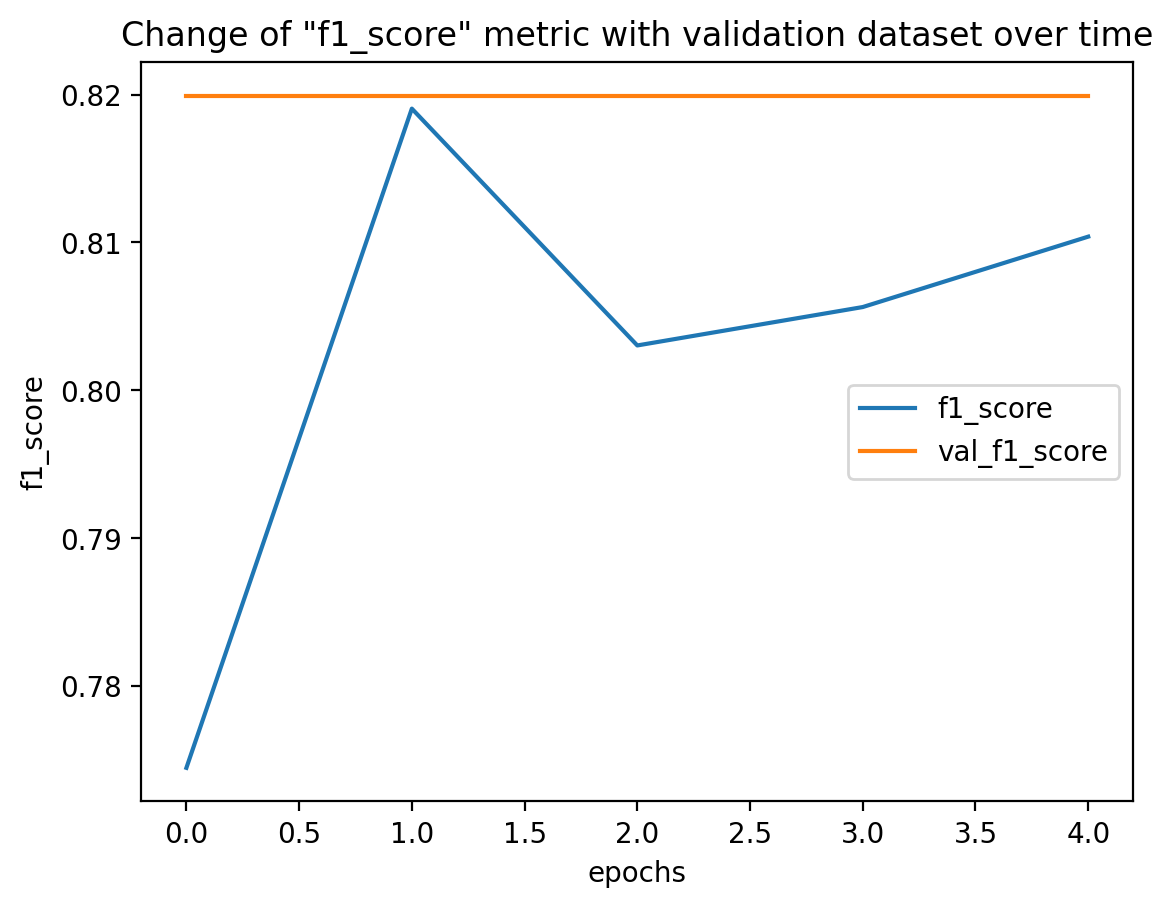

In [17]:
def plot_metric(metric: str, withVal: bool = False) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel("epochs")
    plt.ylabel(metric)

    ax.plot(results.history[metric], label=metric)
    if withVal:
        plt.title(f'Change of "{str(metric)}" metric with validation dataset over time')
        ax.plot(results.history["val_" + str(metric)], label="val_" + str(metric))
    else:
        plt.title(f'Change of "{metric}" metric over time')
    plt.legend(loc="center right")
    plt.show(block=False)


for name in metric_names:
    plot_metric(name)
    if withVal:
        plot_metric(name, withVal)

## <span style="color: yellowgreen;">11. </span> Confusion Matrix and Classification Report



Confusion Matrix:
	---------------------------------
	|	32	|	0	| 
	---------------------------------
	|	12	|	0	|
	---------------------------------

TruePositive	:	32
TrueNegative	:	0
FalsePositive	:	0
FalseNegative	:	12


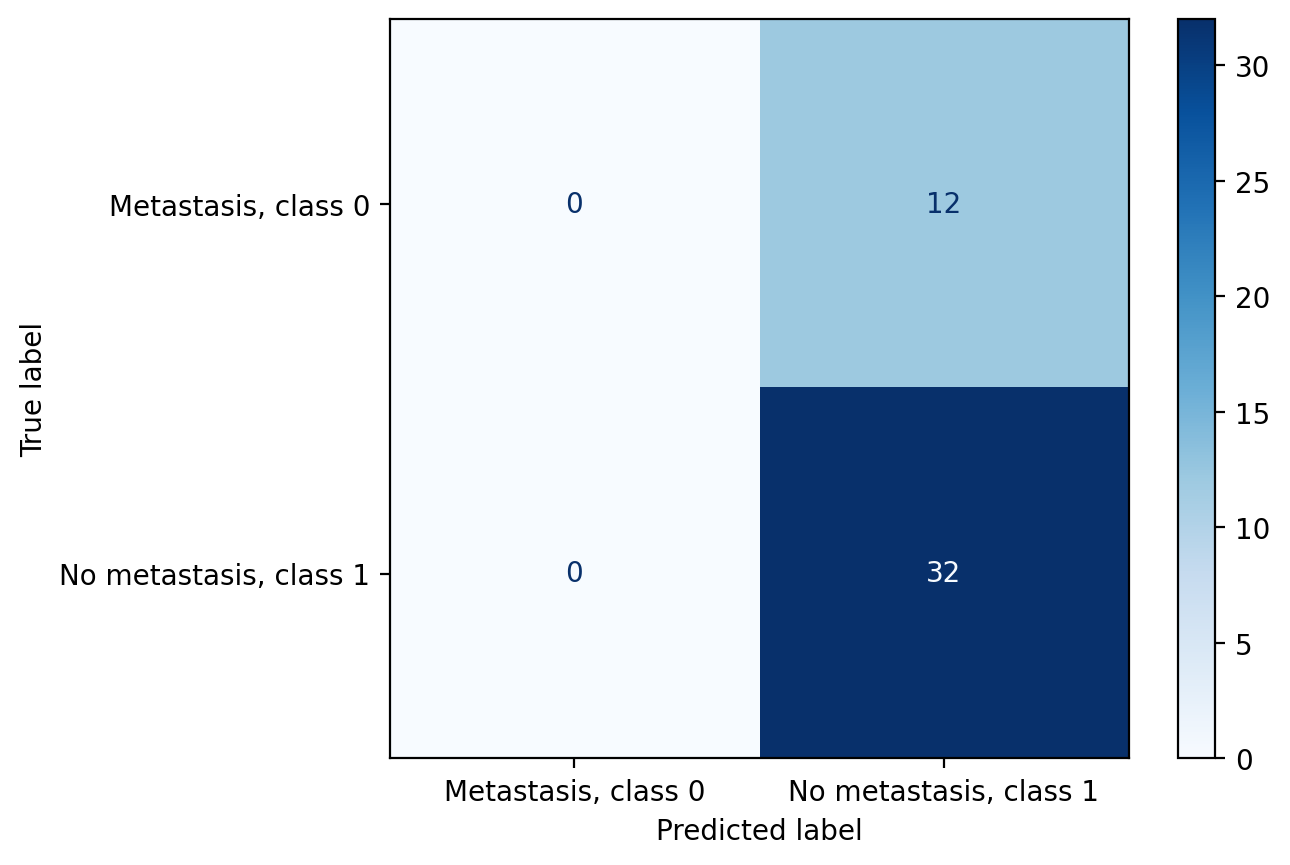

                        precision    recall  f1-score   support

   Metastasis, class 0       0.00      0.00      0.00        12
No metastasis, class 1       0.73      1.00      0.84        32

              accuracy                           0.73        44
             macro avg       0.36      0.50      0.42        44
          weighted avg       0.53      0.73      0.61        44



d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
predictions = (model.predict(testData, verbose=0) > 0.5).astype("int32")

conf_mat = confusion_matrix(y_test, predictions)
confusion = {
    "TruePositive": conf_mat[1][1],
    "TrueNegative": conf_mat[0][0],
    "FalsePositive": conf_mat[1][0],
    "FalseNegative": conf_mat[0][1],
}
accuracy = scores[1]
accuracy = round(accuracy * 100, 2)


def printDict(obj: dict[str, int] = "") -> None:
    if isinstance(obj, dict):
        for k, v in obj.items():
            if hasattr(v, "__iter__"):
                print(k)
                printDict(v)
            else:
                print("%s\t:\t%s" % (k, v))
    elif isinstance(obj, list):
        for v in obj:
            if hasattr(v, "__iter__"):
                printDict(v)
            else:
                print(v)
    else:
        print(obj)


separator = "\t---------------------------------\n"
matrixConfusion = f'\nConfusion Matrix:\n{separator}\t|\t{confusion["TruePositive"]}\t|\t{confusion["FalsePositive"]}\t| \n{separator}\t|\t{confusion["FalseNegative"]}\t|\t{confusion["TrueNegative"]}\t|\n{separator}'
print(matrixConfusion)
printDict(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=TARGET_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(y_test, predictions, target_names=TARGET_NAMES)
print(report)